In [2]:
# data preprossessing
import re
import random
import string
import numpy as np
import unicodedata
from io import open
from sklearn.model_selection import train_test_split
# helper
import time
import math
# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# plt.style.use('ggplot')
plt.style.use('seaborn-darkgrid')
mpl.rcParams["font.size"] = 18
plt.switch_backend('agg') # remove it if using terminal
plt.rcParams["axes.grid"] = False
# torch
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from src.attention.masked_cross_entropy import *
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence


USE_CUDA = False

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# from __future__ import unicode_literals, print_function, division

## * Helper function

In [10]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm-%ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "Time:%s/%s" % (as_minutes(s), as_minutes(rs))
    
def show_plot(points, n_epoches):
    fig, ax = plt.subplots(figsize=(10,6))
    xrange = np.arange(n_epoches+1)
    ax.set_title('Learning Curve')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_xticks(xrange)
    ax.plot(points)
    plt.show()

# 1. Data preparation

In [11]:
class voc:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'PAD', 1: 'SOS', 2: 'EOS'}
        self.n_words = 3  # Count PAD, SOS and EOS
        self.max_length = 1

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
    def addSentence(self, sentence):
        i = 0
        for word in sentence.split():
            self.addWord(word)
            i+=1
        if i > self.max_length:
            self.max_length = i    

## * Clean text: remove punctuations, truncate the length and group into pairs

In [12]:
# remove punctuations
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z]+", r" ", s)
    return s

In [52]:
def read_data(data_path):        
    '''
    Return cleaned a list of pairs, e.g. [[pair1, pair2], [pair3, pair4], ...]
    '''
    # Read the file and split into lines
    lines = open(data_path, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = []
    for i in range(0,len(lines)-1,2):
        pairs.append([normalizeString(lines[i]), normalizeString(lines[i+1])])
    return pairs

In [14]:
# trim the pairs by max_length
def filterPair(p, MAX_LENGTH):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs, MAX_LENGTH):
    return [pair for pair in pairs if filterPair(pair, MAX_LENGTH)]

In [15]:
def prep_data(data_path, MAX_LENGTH):
    '''
    Return voc instance, and trimed and cleaned pairs
    '''
    pairs = read_data(data_path)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, MAX_LENGTH)
    print("Trimmed to %s sentence pairs" % len(pairs))
    # initialize voc instance
    lang = voc()
    print("Counting words...")
    for pair in pairs:
        lang.addSentence(pair[0])
        lang.addSentence(pair[1])
    print("Counted words:")
    print(lang.n_words)
    return lang, pairs

In [16]:
# test things out
data_path = '../data/eminem.txt'
lang, pairs = prep_data(data_path, MAX_LENGTH = 20)
print(random.choice(pairs))

Read 3406 sentence pairs
Trimmed to 3127 sentence pairs
Counting words...
Counted words:
5532
['cause i came saw conquered hit it', 'quit it and made up a plane of bonkers']


In [17]:
pairs = np.array(pairs)

## * Tensorization (pair -> split -> add EOS token -> tensor -> integer encoding)

In [18]:
PAD_token = 0
EOS_token = 2
# batch data
# Return a list of indexes, one for each word in the sentence, plus EOS
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split()] + [EOS_token]

# Pad a with the PAD symbol
def pad_seq(seq, max_length):
    PAD_token = 0
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq

## * Pretrained embeddings

In [19]:
# alternative way to import glove
# from torchnlp.word_to_vector import GloVe

def pretrained(glove_path):
    '''
    load pretrained glove and return it as a dictionary
    '''
    # dimension of import word2vec file
    glove = {}
    with open(glove_path,'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            glove[word] = coefs
    return glove

def embeds(glove_path, EMBEDDING_DIM, non_trainable=True):
    '''
    match pretrained embedding and dataset
    '''
    glove = pretrained(glove_path)
    embedding_matrix = np.zeros((lang.n_words, EMBEDDING_DIM)) # initialization
    # count words that appear only in the dataset. word_index.items() yields dict of word:index pair
    for word, ix in lang.word2index.items():
        embedding_vector = glove.get(word)
        if embedding_vector is not None:
            # words not found in glove matrix will be all-zeros.
            embedding_matrix[ix] = embedding_vector
    # change the datatype from numpy_array to torch_tensor
    weight = torch.FloatTensor(embedding_matrix)
    # convert to the embedding of pytorch
    embedding_matrix = nn.Embedding.from_pretrained(weight)
    # make it non-trainable
    if non_trainable:
        embedding_matrix.weight.requires_grad = False
    
    return embedding_matrix, glove

## * Random batch

In [20]:
def random_batch(batch_size, lang, pairs, USE_CUDA=False):
    '''
    input -> batch_size
    return -> input/output of a batch, array of lengths of input/output
    '''
    
    input_seqs = []
    target_seqs = []

    # integer encoding randomly picked samples of a batch
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexes_from_sentence(lang, pair[0]))
        target_seqs.append(indexes_from_sentence(lang, pair[1]))

    # rearrange seqs in a descending order
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    
    # For input and target sequences, get array of lengths and pad with 0s to max length
    input_lengths = [len(s) for s in input_seqs] # lengths of each seq in a batch
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    # Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
    input_batch = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_batch = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    if USE_CUDA:
        input_batch = input_batch.cuda()
        target_batch = target_batch.cuda()
        
    return input_batch, input_lengths, target_batch, target_lengths

In [21]:
# try it out
batch_size = 3
print(random_batch(batch_size, lang, pairs))

(tensor([[   6,   17,   30],
        [ 144,  225,   26],
        [  49,   35,   41],
        [  23,   71,   65],
        [  11,    9, 2055],
        [ 529,  210, 3398],
        [ 336,   41,   10],
        [  52,  225,   28],
        [  21,  120,   21],
        [ 113,  639,    2],
        [  30, 1015,    0],
        [  26,  258,    0],
        [ 287,  380,    0],
        [  65,    2,    0],
        [ 135,    0,    0],
        [   2,    0,    0]]), [16, 14, 10], tensor([[  10, 1133,   65],
        [ 520,  336, 1196],
        [ 236,    4,  718],
        [  83,  161,  665],
        [ 225,    4, 4785],
        [  44,   46,    2],
        [  45,   49,    0],
        [ 520,    4,    0],
        [  10,   81,    0],
        [1327,  144,    0],
        [  58,   65,    0],
        [ 225,  414,    0],
        [ 162,    2,    0],
        [  16,    0,    0],
        [2282,    0,    0],
        [   2,    0,    0]]), [16, 13, 6])


# 2. Define Model

In [56]:
# encoder that takes batch data
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        # multi-layer, dropout, bidirectional
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs)
        # pack_padded and pad_packed resolve variable length problem of input
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden

In [57]:
# encoder batch data. added zero pad functionality, dropout
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        # bidirectional gru
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden

In [58]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)) # B x S

        if USE_CUDA:
            attn_energies = attn_energies.cuda()

        # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(max_len):
                attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))

        # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
        return F.softmax(attn_energies, dim=1).unsqueeze(1)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.view(-1).dot(encoder_output.view(-1))
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.view(-1).dot(energy.view(-1))
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.v.dot(energy)
            return energy

In [59]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # Get current hidden state from input word and last hidden state
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x S=1 x N

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output)

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

In [60]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(BahdanauAttnDecoderRNN, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = Attn('concat', hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        # TODO: FIX BATCHING
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        word_embedded = self.dropout(word_embedded)
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        context = context.transpose(0, 1) # 1 x B x N
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        output = F.log_softmax(self.out(torch.cat((output, context), 1)), dim=1)
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

# 3. Training fashion

In [61]:
def train(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, USE_CUDA=False):
    
    SOS_token = 1
    batch_size = input_batches.size(1)
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder
    
    # max_length of batch data
    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))

    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target

    # Loss for batch data
    loss = masked_cross_entropy(
    all_decoder_outputs.transpose(0, 1).contiguous(),
    target_batches.transpose(0, 1).contiguous(),
    target_lengths)
    
    # accumulate gradients
    loss.backward()
    
    # Clip gradient norms to prevent exploding gradient issue
    ec = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item(), ec, dc

In [62]:
def trainIter(n_epochs, batch_size, lang, pairs, encoder, decoder, learning_rate = 0.0001, decoder_learning_ratio = 5.0):
    
    loss_array = []
    
    start = time.time()

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
    
    # train/test split
    pairs_train, pairs_test = train_test_split(pairs, test_size=0.2, random_state=666)
    
    epoch = 0
    while epoch < n_epochs:
        
        if epoch%10 ==0: print('{} epochs to run'.format(n_epochs-epoch))

        loss_print = 0
        epoch += 1
        
        
        # Get training data for this cycle
        input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size, lang, pairs_train)

        # Run the train function
        loss, ec, dc = train(input_batches, input_lengths, target_batches, target_lengths,
            encoder, decoder, encoder_optimizer, decoder_optimizer)
        
        loss_array.append(loss)
        ec_array.append(ec)
        dc_array.append(dc)
        loss_print = loss
        
        ######################################################################################
        # validation
        # prepare data for validation
        input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size, lang, pairs_test)
        
        loss = validation(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder)
        
        print('testloss', loss)
        
        
        # print out loss for each epoch
        
        print_summary = "<=== %d%% trained ===> %s loss_train: %.3f loss_test: %.3f <=== dope ===>" % (epoch / n_epochs * 100, time_since(start, epoch / n_epochs), loss_print, loss_print)
        print(print_summary)
    
    return loss_array, ec_array, dc_array
    

# 4. Run model

In [65]:
data_path = '../data/eminem.txt'
MAX_LENGTH = 20
lang, pairs = prep_data(data_path, MAX_LENGTH)

# prepare for encoder/decoder
n_layers = 2
hidden_size = 8
dropout=0.1
encoder = EncoderRNN(lang.n_words, hidden_size, n_layers)
decoder = LuongAttnDecoderRNN('general', hidden_size, lang.n_words, n_layers, dropout)
USE_CUDA = False
if USE_CUDA:
	    encoder = encoder.cuda()
	    decoder = decoder.cuda()

# Training
batch_size = 50
n_epochs = 20
clip = 50.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0

loss_array, ec_array, dc_array = trainIter(n_epochs, batch_size, lang, pairs, encoder, decoder, learning_rate, decoder_learning_ratio)

Read 3406 sentence pairs
Trimmed to 3127 sentence pairs
Counting words...
Counted words:
5532
20 epochs to run


AssertionError: Torch not compiled with CUDA enabled

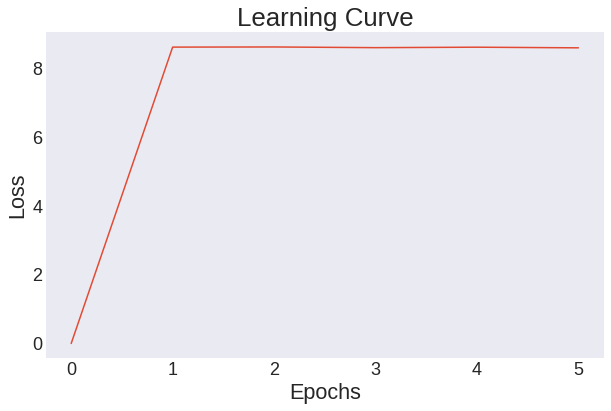

In [307]:
show_plot(loss_array, n_epochs)

# 5. Evaluation

In [145]:
def evaluate(encoder, decoder, input_seq, max_length=MAX_LENGTH):
    SOS_token = 1
    with torch.no_grad():
        
        input_seqs = [indexes_from_sentence(lang, input_seq)]
        input_batches = Variable(torch.LongTensor(input_seqs)).transpose(0, 1)
        input_lengths = [len(input_batches)]
        if USE_CUDA:
            input_batches = input_batches.cuda()

        # Run through encoder
        encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

        # Create starting vectors for decoder
        decoder_input = Variable(torch.LongTensor([SOS_token])) # SOS
        decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

        if USE_CUDA:
            decoder_input = decoder_input.cuda()

        # Store output words and attention states
        decoded_words = []
        decoder_attentions = torch.zeros(max_length + 1, max_length + 1)

        # Run through decoder
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

            # Choose top word from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi.item()
            if ni == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(lang.index2word[ni])

            # Next input is chosen word
            decoder_input = Variable(torch.LongTensor([ni]))
            if USE_CUDA: decoder_input = decoder_input.cuda()

        # Set back to training mode
        encoder.train(True)
        decoder.train(True)
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

In [155]:
def evaluate_randomly():
    [input_sentence, target_sentence] = random.choice(pairs)
    evaluate_and_show_attention(input_sentence, target_sentence)

In [252]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig, ax = plt.subplots(figsize=(10,8))
    att = ax.imshow(attentions.numpy(), cmap='Greens', aspect='auto')
    cbar = fig.colorbar(att, ax=ax)
    
    ax.set_title('Attention Visualization')
    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=0)
    ax.set_yticklabels([''] + output_words)
    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [309]:
def evaluate_and_show_attention(input_sentence, encoder, decoder, target_sentence=None):

    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    output_sentence = ' '.join(output_words)
    print('Seed_text', input_sentence)
    if target_sentence is not None:
        print('OG_lyrics', target_sentence)
    print('Generated_lyrics', output_sentence)

    show_attention(input_sentence, output_words, attentions)

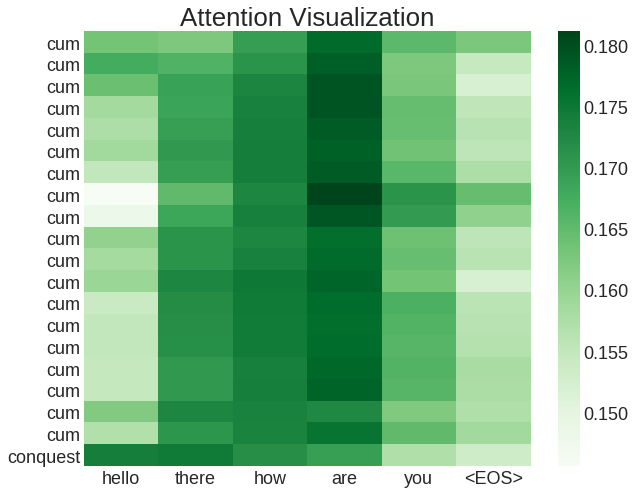

In [310]:
output_words, attentions = evaluate(encoder, decoder, "hello there how are you")
show_attention('hello there how are you', output_words, attentions)
# plt.figure(figsize=(15,10))
# sns.heatmap(attentions.numpy())

Seed_text hello there
Generated_lyrics conquest cum la la la la fantastic fantastic la fantastic la la chairs fantastic fantastic fantastic la la conquest la


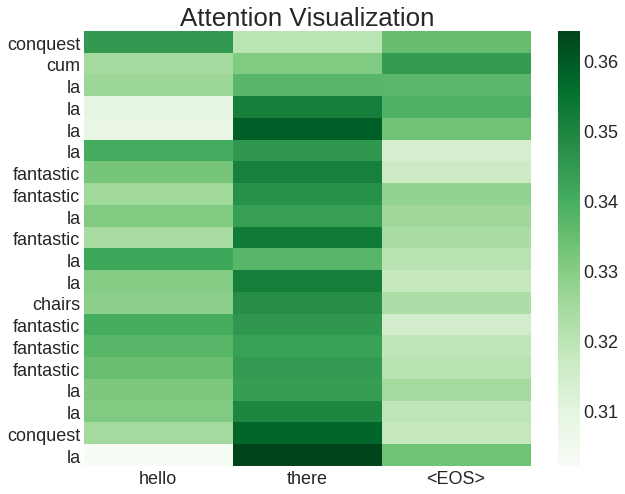

In [311]:
evaluate_and_show_attention('hello there', encoder, decoder, target_sentence=None)

# Validation

In [318]:
def validation(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder):
    '''
    This function will run on one sample
    input_tensor, target_tensor -> integer encoded
    encoder, decoder -> instantiated encoder and decoder
    criterion -> will be given in trainIter
    max_length -> required to build encoder_outputs
    
    returns: averaged loss, correctly predicted words, total words predicted
    '''
    SOS_token = 1
    with torch.no_grad():
        loss = 0
        # take the whole validation set as a batch
        batch_size = input_batches.size(1)

        # Run words through encoder
        encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

        # Prepare input and output variables
        decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
        decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

        # max_length of batch data
        max_target_length = max(target_lengths)
        all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))

        # Move new Variables to CUDA
        if USE_CUDA:
            decoder_input = decoder_input.cuda()
            all_decoder_outputs = all_decoder_outputs.cuda()

        # Run through decoder one time step at a time
        for t in range(max_target_length):
            decoder_output, decoder_hidden, decoder_attn = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            all_decoder_outputs[t] = decoder_output
            decoder_input = target_batches[t] # Next input is current target

        # Loss for batch data
        loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(),
        target_batches.transpose(0, 1).contiguous(),
        target_lengths)
    
    return loss.item()

# Messy test below

In [38]:
# Define model
class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = TheModelClass()
# Initialize optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [139820002543656, 139822060606304, 139820002189960, 139820002189672, 139820002190248, 139820002190320, 139820002190176, 139820002190032, 139820002190104, 139820002189888]}]


In [39]:
torch.save(model.state_dict(), '../model/test')

In [3]:
a = np.array([1,2,3])
b= a

In [4]:
a+b

array([2, 4, 6])

In [8]:
np.concatenate((a,b), axis = 0)

array([1, 2, 3, 1, 2, 3])

In [25]:
a = [1,2,3]
c = [5,6,7]
np.save('test', a)
b = np.load('test.npy').tolist()

In [26]:
c +=a
c

[5, 6, 7, 1, 2, 3]

In [16]:
b.tolist()

[1, 2, 3]